<a href="https://colab.research.google.com/github/Jobairshi/BookStore_Asp/blob/main/GRADCAM_%2B_HEAD_SimpleHRNet_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple HRNet
This is a light Google Colab notebook showing how to use the [simple-HRNet](https://github.com/stefanopini/simple-HRNet) repository.

It includes the conversion to TensorRT and a test of the converted model.
Please skip the section "TensorRT" if not interested.

Initial idea of running on Google Colab by @basicvisual, initial implementation by @wuyenlin (see [issue #84](https://github.com/stefanopini/simple-HRNet/issues/84)).

## Pytorch

### Clone the repo and install the dependencies

In [1]:
# clone the repo
!git clone https://github.com/stefanopini/simple-HRNet.git

Cloning into 'simple-HRNet'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 420 (delta 85), reused 73 (delta 73), pack-reused 319 (from 1)
Receiving objects: 100% (420/420), 78.05 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [2]:
%cd simple-HRNet
!pwd

/content/simple-HRNet
/content/simple-HRNet


In [3]:
# install requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00


In [4]:
# install vlc to get video codecs
!apt install vlc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-freefont-ttf liba52-0.7.4 libaa1 libaribb24-0 libcddb2 libdca0 libdvbpsi10 libdvdnav4
  libdvdread8 libebml5 libevdev2 libfaad2 libgudev-1.0-0 libidn12 libinput-bin libinput10 libixml10
  libjansson4 libkate1 libldb2 liblirc-client0 liblmdb0 liblua5.2-0 liblzo2-2 libmad0 libmatroska7
  libmd4c0 libmpcdec6 libmpeg2-4 libmtdev1 libmtp-common libmtp-runtime libmtp9 libnfs13 libnotify4
  libopenmpt-modplug1 libplacebo192 libprotobuf-lite23 libproxy-tools libproxy1v5 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libqt5x11extras5
  libresid-builder0c2a libsdl-image1.2 libsdl1.2debian libsecret-1-0 libsecret-common libshout3
  libsidplay2 libsmbclient libspatialaudio0 libspeexdsp1 libtag1v5 libtag1v5-vanilla libtalloc2
  libtdb1 libtevent0 libudev1 libupnp13 libva-wayland2 libvlc-bin libvlc5 libvlccore9 l

### Add yolov3
Clone yolov3 for multiprocessing support. This can be skipped for single-person applications or if you plan to use YOLO v5 by Ultralytics.

In [5]:
# download git submodules
!git submodule update --init --recursive

Submodule 'models/detectors/yolo' (https://github.com/eriklindernoren/PyTorch-YOLOv3) registered for path 'models_/detectors/yolo'
Cloning into '/content/simple-HRNet/models_/detectors/yolo'...
Submodule path 'models_/detectors/yolo': checked out '47b7c912877ca69db35b8af3a38d6522681b3bb3'


In [6]:
%cd /content/simple-HRNet/models_/detectors/yolo
!pip install -q -r requirements.txt

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo
/content/simple-HRNet


In [7]:
%cd /content/simple-HRNet/models_/detectors/yolo/weights
!sh download_weights.sh

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo/weights
--2024-11-22 05:37:36--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  36.9MB/s    in 6.5s    

2024-11-22 05:37:43 (36.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-22 05:37:43--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  29.0MB/s    in 1.2s    

2024-11-22 05:37:44 (29.0 MB/s) - ‘yolo

### Download HRNet pre-trained weights and test video

Download any of the supported official weights listed [here](https://github.com/stefanopini/simple-HRNet/#installation-instructions).

In the following, we download the weights `pose_hrnet_w48_384x288.pth` from the official Drive link.
Download of other weights (e.g. `pose_hrnet_w32_256x192.pth`) as well as weights from private Drives is supported too.

In [8]:
!pip install --upgrade --no-cache-dir gdown

In [9]:
# download weights

# create weights folder
%cd /content/simple-HRNet
!mkdir weights
%cd /content/simple-HRNet/weights

# download weights pose_hrnet_w48_384x288.pth
!gdown 1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS

# download weights pose_hrnet_w32_256x192.pth
!gdown 1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38

# download weights pose_hrnet_w32_256x256.pth
!gdown 1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v

# # download weights from your own Google Drive
# from glob import glob
# from google.colab import drive
# drive.mount('/content/drive')
# w_list = glob("/content/drive/<your drive folder>/*.pth")
# if not w_list:
#   raise FileNotFoundError("You haven't downloaded any pre-trained weights!")

%cd /content/simple-HRNet

/content/simple-HRNet
/content/simple-HRNet/weights
Downloading...
From (original): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS
From (redirected): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS&confirm=t&uuid=36b9f6b6-d7cf-46cd-b5c1-65d3a1ce0957
To: /content/simple-HRNet/weights/pose_hrnet_w48_384x288.pth
100% 255M/255M [00:05<00:00, 46.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38
From (redirected): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38&confirm=t&uuid=9ecd0174-347a-4ff4-83af-754fae2db096
To: /content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth
100% 115M/115M [00:01<00:00, 77.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v
From (redirected): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v&confirm=t&uuid=a5f437f4-ffc3-4d9c-911b-e7ca45c18443
To: /content/simple-HRNet/weights/pose_hrnet_w32_

In [11]:
# download a publicly available video (or just get your own)
!wget https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4

--2024-11-22 05:38:20--  https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4
Resolving commondatastorage.googleapis.com (commondatastorage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to commondatastorage.googleapis.com (commondatastorage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13183260 (13M) [video/mp4]
Saving to: ‘WeAreGoingOnBullrun.mp4.1’

WeAreGoingOnBullrun 100%[===================>]  12.57M  79.6MB/s    in 0.2s    

2024-11-22 05:38:20 (79.6 MB/s) - ‘WeAreGoingOnBullrun.mp4.1’ saved [13183260/13183260]



### Test the API


In [32]:
import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
from PIL import Image
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # singleperson, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", multiperson=False, device=device)

# # multiperson w/ YOLOv3, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", device=device)

# # multiperson w/ YOLOv3, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", device=device)

# # multiperson w/ YOLOv3, MPII weights
# model = SimpleHRNet(32, 16, "./weights/pose_hrnet_w32_256x256.pth", device=device)

# # multiperson w/ YOLOv5 (medium), COCO weights
model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", yolo_version='v5', yolo_model_def='yolov5m', device=device)

# multiperson w/ YOLOv5 nano, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", yolo_version='v5', yolo_model_def='yolov5n', device=device)

url = 'http://images.cocodataset.org/val2017/000000097278.jpg'
im = Image.open(requests.get(url, stream=True).raw)
image = io.imread(url)

joints = model.predict(image)

device: 'cuda' - 1 GPU(s) will be used


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-22 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


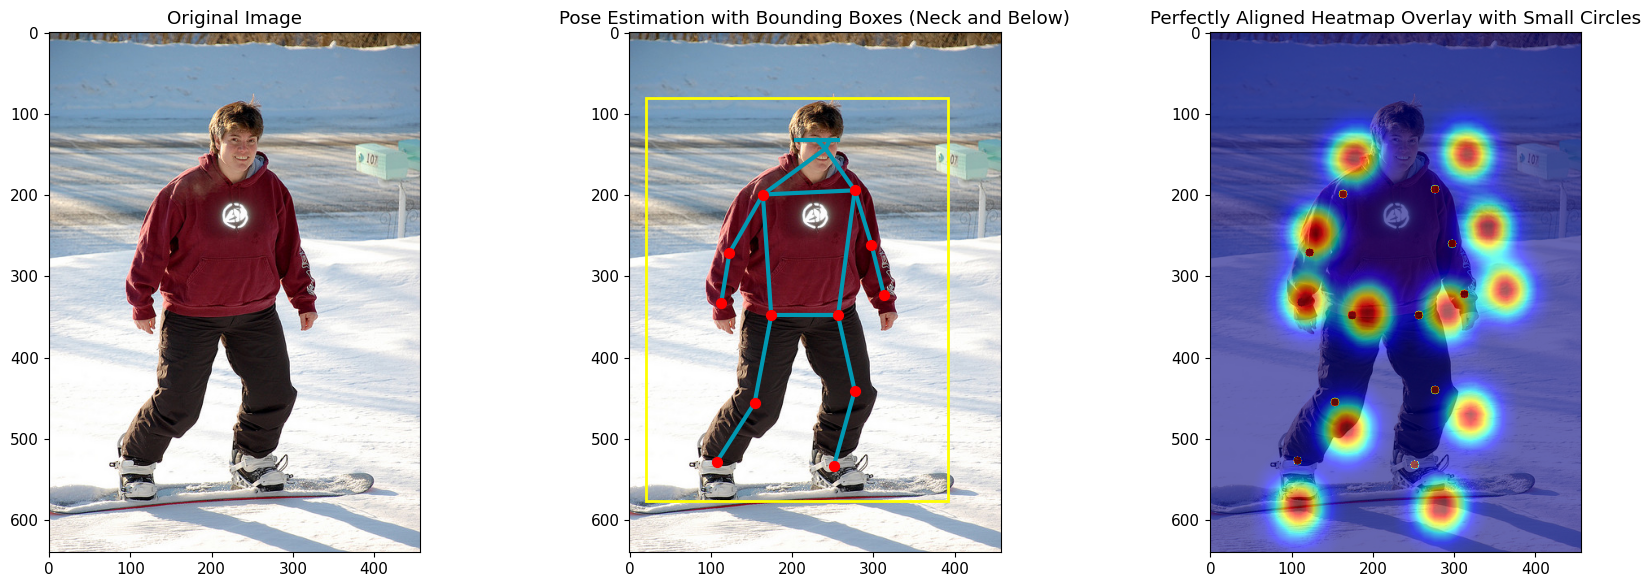

In [44]:
def plot_heatmaps_for_all_joints(ax, joints, heatmaps, original_image_shape):
    # Exclude heatmaps for head joints (0, 1, 2, 3, 4)
    excluded_joints = [0, 1, 2, 3, 4]

    # Initialize an empty array for the combined heatmap
    combined_heatmap = np.zeros((original_image_shape[0], original_image_shape[1]), dtype=np.float32)

    # Loop over each person and joint heatmap
    for person_idx, person_heatmaps in enumerate(heatmaps):
        for joint_idx, joint_heatmap in enumerate(person_heatmaps):
            if joint_idx in excluded_joints:
                continue  # Skip heatmaps for head joints

            # Resize the joint's heatmap to match the original image size
            heatmap_resized = cv2.resize(joint_heatmap, (original_image_shape[1], original_image_shape[0]), interpolation=cv2.INTER_LINEAR)

            # Normalize the heatmap for proper visualization
            if heatmap_resized.max() > 0:
                heatmap_resized /= heatmap_resized.max()

            # Add the resized heatmap to the combined heatmap
            combined_heatmap += heatmap_resized

        # Overlay individual joint locations as smaller circles
        for joint_idx, (y, x, confidence) in enumerate(joints[person_idx]):
            if joint_idx in excluded_joints or confidence <= 0.5:
                continue  # Skip head joints and low-confidence joints

            # Draw small circles at the exact joint positions
            circle = np.zeros_like(combined_heatmap, dtype=np.float32)
            cv2.circle(circle, (int(x), int(y)), 5, 1, thickness=-1)  # Circle radius = 5
            combined_heatmap += circle

    # Normalize the combined heatmap to ensure values are between 0 and 1
    combined_heatmap = np.clip(combined_heatmap, 0, 1)

    # Display the heatmap overlay
    ax.imshow(combined_heatmap, cmap='jet', alpha=0.6)  # Adjust alpha for better visibility


# Plotting results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axs[0].imshow(image_rgb)
axs[0].set_title("Original Image")

# Bounding Boxes and Joints
axs[1].imshow(image_rgb)
plot_joints_and_bboxes(axs[1], joints, bounding_boxes)
axs[1].set_title("Pose Estimation with Bounding Boxes (Neck and Below)")

# Heatmap for all joints of all people
axs[2].imshow(image_rgb)
plot_heatmaps_for_all_joints(axs[2], joints, heatmaps, image_rgb.shape)
axs[2].set_title("Perfectly Aligned Heatmap Overlay with Small Circles")

plt.tight_layout()
plt.show()


my part grad

In [46]:
!pip install ipython matplotlib numpy tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


In [47]:
!pip install requests

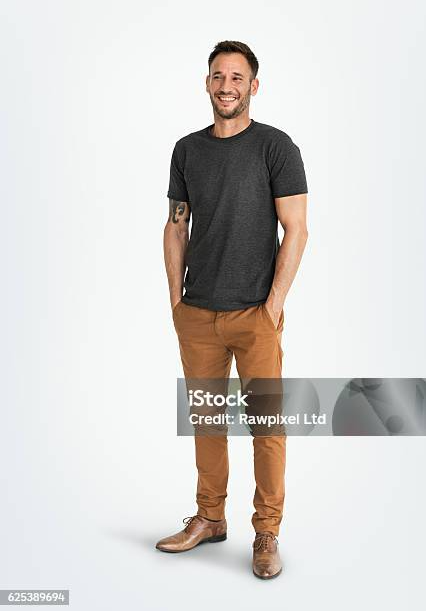

In [49]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# model_builder = keras.applications.resnet50.ResNet50
# img_size = (224, 224)  # ResNet50 uses 224x224 images
# preprocess_input = keras.applications.resnet50.preprocess_input
# decode_predictions = keras.applications.resnet50.decode_predictions

# last_conv_layer_name = "conv5_block3_out"  # ResNet50's last conv layer name


# model_builder = keras.applications.vgg16.VGG16
# img_size = (224, 224)  # VGG16 uses 224x224 images
# preprocess_input = keras.applications.vgg16.preprocess_input
# decode_predictions = keras.applications.vgg16.decode_predictions

# last_conv_layer_name = "block5_conv3"  # VGG16's last conv layer name

## The local path to our target image

img_path= "/content/simple-HRNet/Screenshot 2024-11-22 120758.png"

display(Image(img_path))
def get_img_array(img_path, size):
    ## `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted of image: [('n03255030', 'dumbbell', 6.4580383)]


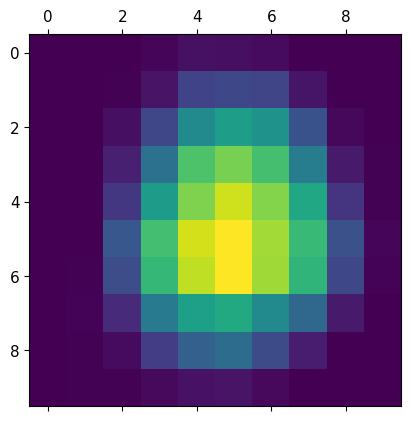

In [50]:
## Preparing the image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

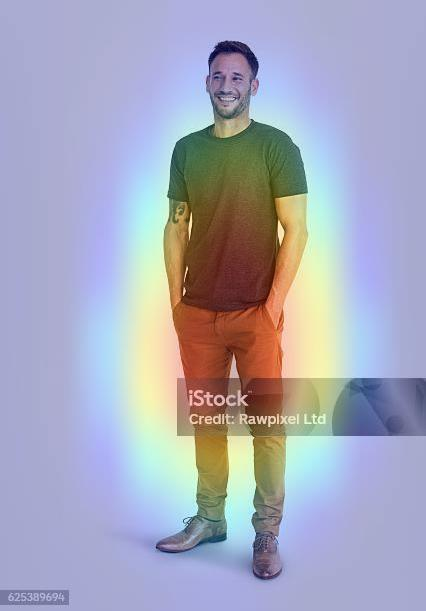

In [51]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Test the live script
This step can be skipped if interested in the TensorRT conversion.

In [45]:
# # test the live script with default params (multiperson with yolo v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video

# # test the live script with tiny yolo (v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --use_tiny_yolo

# # test the live script with yolo v5
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5

# test the live script with tiny yolo v5 (tensorrt yolo v5)
!python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5 --use_tiny_yolo

/content/simple-HRNet/SimpleHRNet.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=self.device)
device: 'cuda' - 1

Now check out the video output.avi


## TensorRT
This section install TensorRT 8.5, converts the model to TensorRT (.engine) and tests the converted model.

Tested with TensorRT 8.5.1-1+cuda11.8 and python package tensorrt 8.5.1.7 .

### Install TensorRT
A GPU is needed for this step. Please change the runtime type to "GPU".


In [ ]:
# check a GPU runtime is selected
!nvidia-smi

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer8 python3-libnvinfer

In [ ]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

In [ ]:
# install TensorRT for python
!pip install tensorrt

In [ ]:
# clone the converion tool torch2trt
%cd /content
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt

In [ ]:
# install torch2trt
%cd /content/torch2trt
!python setup.py install

In [ ]:
%cd /content/simple-HRNet

### Export the model with tensorrt

In [ ]:
# Convert the smaller HRNet model to TensorRT - it may take a while...
!python scripts/export-tensorrt-model.py --half \
     --weights "./weights/pose_hrnet_w32_256x192.pth" --hrnet_c 32 --image_resolution '(256, 192)'

#### [Optional] Export yolov5 with TensorRT

In [ ]:
# Optional - Convert yolov5 (nano) to tensorrt too
!python /root/.cache/torch/hub/ultralytics_yolov5_master/export.py --weights yolov5n.pt --include engine --device 0 --half

### Test the tensorrt model

In [ ]:
# Run inference with the converted TensorRT model
!python scripts/live-demo.py --enable_tensorrt --filename=WeAreGoingOnBullrun.mp4 --hrnet_weights='weights/hrnet_trt.engine' \
  --hrnet_c 32 --image_resolution "(256, 192)" --yolo_version v5 --use_tiny_yolo --save_video


Now check out the video output.avi
